<a href="https://colab.research.google.com/github/Justin-Jonany/AutoPartner/blob/main/autopartner_improved_blending_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoPartner
This dataset is retrieved from https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge/data.

### Goal
The goal of this notebook is to create an effective model to predict car sales price. However, this notebook is an extension of the previous notebook where I'm going to implement an imrpoved blending algorithm with neural networks

### Attributes
1. ID
2. Price: price of the care(Target Column)
3. Levy
4. Manufacturer
5. Model
6. Prod. year
7. Category
8. Leather interior
9. Fuel type
10. Engine volume
11. Mileage
12. Cylinders
13. Gear box type
14. Drive wheels
15. Doors
16. Wheel
17. Color
18. Airbags

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from statistics import mean
from sklearn.preprocessing import StandardScaler, normalize

import seaborn as sns

## Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/projects/AutoPartner/car_price_prediction.csv")
df.shape

(19237, 18)

### Splitting Data Into Training, Validation, and Test Set
Note that unlike the previous notebook, here I'm going to create a validation set too

we need to classify the **Price** column into a few categories in order to **stratify split** the data.

In [ ]:
df["Price_cat"] = pd.cut(df["Price"],
                               bins=[0., 4000, 8000, 12000, 14000, 18000, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

In [ ]:
df.Price_cat.value_counts()

6    6681
1    4174
3    2584
5    2429
2    2228
4    1141
Name: Price_cat, dtype: int64

In [ ]:
df.shape

(19237, 19)

In [ ]:
df_train_val, df_test = train_test_split(df, stratify=df['Price_cat'], test_size=0.18)
df_train_val.shape, df_test.shape

((15774, 19), (3463, 19))

In [ ]:
df_train, df_val = train_test_split(df_train_val, stratify=df_train_val['Price_cat'], test_size=0.12)
df_train.shape, df_val.shape

((13881, 19), (1893, 19))

In [ ]:
df_train.Price_cat.value_counts(len(df_train))

6    0.347237
1    0.216987
3    0.134356
5    0.126288
2    0.115842
4    0.059290
Name: Price_cat, dtype: float64

In [ ]:
df_val.Price_cat.value_counts(len(df_train))

6    0.347596
1    0.217116
3    0.134179
5    0.126255
2    0.115689
4    0.059165
Name: Price_cat, dtype: float64

In [ ]:
df_test.Price_cat.value_counts(len(df_test))

6    0.347387
1    0.216864
3    0.134277
5    0.126191
2    0.115796
4    0.059486
Name: Price_cat, dtype: float64

Both training and testing set have proportional target labels, so now we can remove `Price_label` from both sets

In [ ]:
df_test.drop('Price_cat', axis=1, inplace=True);
df_train.drop('Price_cat', axis=1, inplace=True);
df_val.drop('Price_cat', axis=1, inplace=True);

### Data Preprocessing

For explaination, look at the previous notebook


In [ ]:
def detect_outliers(df,features,thold):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * thold
        # Detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # Store indeces
        outlier_indices.extend(outlier_list_col)


    return outlier_indices

In [ ]:
NUM_ATTRIBS = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Doors', 'Cylinders', 'Airbags']
CAT_ATTRIBS = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
               'Gear box type', 'Drive wheels', 'Wheel', 'Color', 'Turbo']

In [ ]:
class DropID(BaseEstimator, TransformerMixin):
    '''
    A transformer to drop ID
    '''
    def __init__(self, drop=True):
        self.drop = drop
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X = X.drop(['ID'], axis=1)

        return X

In [ ]:
class CustomImputer(BaseEstimator, TransformerMixin):
    '''
    A transformer to remove all instances with '-' in the Levy column if drop=True (default),
    or change to np.nan if drop=False
    '''
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X['Levy'].replace({'-':np.nan}, inplace = True)

        return X

In [ ]:
class ConvertToNumerical(BaseEstimator, TransformerMixin):
    '''
    A transformer to convert 'Levy', 'Engine Volume', 'Mileage', and 'Doors' into clean
    and numeric data. Also, optionally remove_outliers for Levy, Price, and Mileage. We
    also add a new feature 'Turbo'.

    '''
    def __init__(self, remove_outliers=False):
        self.remove_outliers = remove_outliers
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X['Levy'] = X['Levy'].astype('float64')
        X['Levy'].replace({np.nan:X['Levy'].median()}, inplace = True)
        X['Turbo'] = [(1 if len(s) > 3 else 0) for s in X['Engine volume']]
        X['Engine volume'] = np.array([s[:3] for s in X['Engine volume']]).astype(float)
        X['Mileage'] = np.array([s[:len(s) - 2] for s in X['Mileage']]).astype(int)
        X['Doors'].replace({'04-May':4, '02-Mar':2, '>5':5}, inplace=True)

        if self.remove_outliers:
            print('Removing Outliers in columns: Price, Levy, and Mileage')
            features = ['Price', 'Levy', 'Mileage']
            outliers = detect_outliers(X,features, 1.5)
            X.drop(X.loc[outliers].index,axis=0, inplace=True)

        return X

In [ ]:
class ConvertToFloat(BaseEstimator, TransformerMixin):
    '''
    Converts all columns to float
    '''
    def __init__(self, remove_outliers=False):
        self.remove_outliers = remove_outliers
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        for i in NUM_ATTRIBS:
            X[i] = X[i].astype(float)
        return X

In [ ]:
# NUM ATTRIBUTES
pipeline_numerical_unstandardized = Pipeline([
    ('drop_id', DropID()),
    ('custom_imputer', CustomImputer()),
    ('convert_to_numerical', ConvertToNumerical()),
])

pipline_numerical_standardize = ColumnTransformer([
    ('standardize', StandardScaler(), NUM_ATTRIBS)
], remainder='passthrough')


names = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Doors', 'Cylinders', 'Airbags', 'Price',
         'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels',
        'Wheel', 'Color', 'Turbo']

# Note: we have to separate standardizing and cleaning because when we clean, we can remove
# some instances in some cases. Changing shapes in ColumnTransformer doesn't work, but we need
# ColumnTransformer for StandardScaler(). Therefore, we make sure to do any instances changes before
pipeline_numerical_full = Pipeline([
    ('cleaning_numeric', pipeline_numerical_unstandardized),
    ('standardize',pipline_numerical_standardize),
    ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = names))),
    ('reconvert_to_float', ConvertToFloat())
    # pandas is buggy and requires each column to be converted to float again for some reason, or else the
    # dtype will be 'object'
])


# ====================================================================================================

# CATEGORICAL ATTRIBUTES
pipeline_cat_full = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown='ignore'), CAT_ATTRIBS),
    ], remainder='passthrough')

### Splitting Data into X & y

In [ ]:
def full_pipeline(df, training=False):
    '''
    Cleans the data and add a new feature. Outliers will be removed if it's the training data. It will
    return the X and y in a tuple.
    '''
    if training:
        new_df = pipeline_numerical_full.set_params(
                                            cleaning_numeric__convert_to_numerical__remove_outliers=True).fit_transform(df)
        X = new_df.drop('Price', axis = 1)
        encoded_X = pipeline_cat_full.fit_transform(X)

    else:
        new_df = pipeline_numerical_full.transform(df)
        X = new_df.drop('Price', axis = 1)
        encoded_X = pipeline_cat_full.transform(X)

    y = new_df['Price']

    return encoded_X, y


In [ ]:
X_train, y_train = full_pipeline(df_train, training=True)
X_val, y_val = full_pipeline(df_val)
X_test, y_test = full_pipeline(df_test)

Removing Outliers in columns: Price, Levy, and Mileage
Removing Outliers in columns: Price, Levy, and Mileage
Removing Outliers in columns: Price, Levy, and Mileage


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = X_train.astype(float), y_train.astype(float), X_val.astype(float), y_val.astype(float), X_test.astype(float), y_test.astype(float)

## Previous Best Model
The project was made quite early in the beginning of my journey, and I didn't save the model properly. So, I'll attach an image from the previous notebook.

![image](https://drive.google.com/uc?export=view&id=1g8ppaUiQHGHlS2-bHo6CvWxdtsk8TiGJ)


So the goal is to have an RMSE lower than 5230.980

## Model Trainings

### Scikit-Learn RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = rfr.predict(X_val)
rfr_result = tf.sqrt(mean_squared_error(y_val, y_pred))
rfr_result

<tf.Tensor: shape=(), dtype=float64, numpy=5155.783716341994>

In [ ]:
y_pred = rfr.predict(X_test)
rfr_result = tf.sqrt(mean_squared_error(y_test, y_pred))
rfr_result

<tf.Tensor: shape=(), dtype=float64, numpy=5640.996175230046>

### Blending Algorithm

Let's restart the blending algorithm in the previous notebook

Blending is an ensemble machine learning technique that uses a machine learning model to learn how to best combine the predictions from multiple contributing ensemble member models.

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model. The meta-model is trained on the predictions made by base models on out-of-sample data.

* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

Here, I'm going to implement the level-0 with the following base models:
- Linear Regression
- SVR
- K-Nearest Neighbour Regression
- Random Forest Regressor
- XGBoost
- AdaBoost

It's best to use models that have different predictive methods


Finally, I'm going to use a linear regression to learn to combine the prediction of the base models (**the blender**)

This is **Multi Layered Perceptron (MLP)**, since there's no hidden layers

In [ ]:
X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(X_train, y_train, test_size=0.33)
X_train_blend.shape, X_val_blend.shape, y_train_blend.shape, y_val_blend.shape

((7102, 1205), (3499, 1205), (7102,), (3499,))

In [ ]:
X_train_blend_val, X_val_blend_val, y_train_blend_val, y_val_blend_val = train_test_split(X_val, y_val, test_size=0.33)
X_train_blend_val.shape, X_val_blend_val.shape, y_train_blend_val.shape, y_val_blend_val.shape

((986, 1205), (487, 1205), (986,), (487,))

In [ ]:
X_train_blend_test, X_val_blend_test, y_train_blend_test, y_val_blend_test = train_test_split(X_test, y_test, test_size=0.33)
X_train_blend_test.shape, X_val_blend_test.shape, y_train_blend_test.shape, y_val_blend_test.shape

((1754, 1205), (864, 1205), (1754,), (864,))

#### First Layer
Training the models and combining the predictions

In [ ]:
def get_models():
    models = list()
    models.append(('lr', LinearRegression()))
    models.append(('knn', KNeighborsRegressor()))
    models.append(('svm', SVR()))
    models.append(('rfr', RandomForestRegressor()))
    models.append(('xgb', XGBRegressor()))
    models.append(('abr', AdaBoostRegressor()))
    return models

In [ ]:
def prediction_combiner(models, X_train_b, X_val_b, y_train_b, y_val_b):
    '''
    Fits X_train and y_train into models and create predictions on X_val. The results will be combined
    into a matrix, which will be used to train the blender. The function returns the trained blender.
    '''

    # To Hold all the predictions
    meta_X = list()

    for name, model in models:
        # Train on the training set
        model.fit(X_train_b, y_train_b)

        # Predict on hold-out set
        y_pred = model.predict(X_val_b)
        y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
        meta_X.append(y_pred)

    meta_X = np.hstack(meta_X) # Shapes meta_X into the correct format for training data
    return meta_X

#### Second Layer
Making predictions

In [ ]:
def predict_ensemble(models, blender, X):
    '''
    Returns the predictions of X using the blender
    '''
    # We need to create the meta_X from the models we already trained
    meta_X = list()
    for name, model in models:
        y_pred = model.predict(X)
        y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
        meta_X.append(y_pred)

    meta_X = np.hstack(meta_X)

    return blender.predict(meta_X)


#### Using the blending algorithm

In [ ]:
models = get_models()
meta_X = prediction_combiner(models, X_train_blend, X_val_blend, y_train_blend, y_val_blend)
blender = LinearRegression()
blender.fit(meta_X, y_val_blend)
y_pred = predict_ensemble(models, blender, X_train)

blending_score = np.sqrt(mean_squared_error(y_train, y_pred))

print('Blending RMSE: ', blending_score)


Blending RMSE:  3764.0138494097664


#### Turning it into a custom blending estimator

In [ ]:
class Blending(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, models):
        X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X, y, test_size=0.33)

        meta_X = list()

        for name, model in models:
            # Train on the training set
            model.fit(X_train_b, y_train_b)

            # Predict on hold-out set
            y_pred = model.predict(X_val_b)
            y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
            meta_X.append(y_pred)

        meta_X = np.hstack(meta_X) # Turning into the correct format

        self.blender = LinearRegression() # Our blender / meta-model
        self.blender.fit(meta_X, y_val_b)
        self.models = models

        return self

    def predict(self, X):
        # We need to create the meta_X from the models we already trained
        meta_X = list()
        for name, model in self.models:
            y_pred = model.predict(X)
            y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
            meta_X.append(y_pred)

        meta_X = np.hstack(meta_X)
        print(meta_X)
        return self.blender.predict(meta_X)

In [ ]:
bl = Blending()

In [ ]:
bl.fit(X_train, y_train, get_models())

Blending()

#### Evaluation on validation set
Let's see performance on the validation set

In [ ]:
X_train

<10601x1205 sparse matrix of type '<class 'numpy.float64'>'
	with 180217 stored elements in Compressed Sparse Row format>

In [ ]:
X_val

<1473x1205 sparse matrix of type '<class 'numpy.float64'>'
	with 24933 stored elements in Compressed Sparse Row format>

In [ ]:
y_pred = bl.predict(X_val)
y_pred[:10]

[[ 9266.84271984  1850.4        13597.18041616  4680.74
   2516.71484375 13332.33913043]
 [13784.13906393 10411.6        13462.79995044 12269.41
  15401.6328125  11715.6860177 ]
 [13354.44423706 12482.         13518.55176079  7297.29
  11801.80175781 13055.29120559]
 ...
 [30869.38548029 16373.6        13741.58720931 16443.75
  14698.61523438 19645.95801527]
 [19559.2693749   8009.8        13528.69461295 13052.29
  15643.04101562 16874.38461538]
 [11223.93963229 20330.6        13476.42496138 16849.34
  15708.00097656 20281.68552036]]


array([ 3187.45341606, 13176.5614757 ,  9549.55775819, 37316.55959593,
       21160.30646819,  9966.13309348,  6493.24485229,  7787.83519025,
       16580.1594137 ,  6596.23946922])

In [ ]:
bl_score = np.sqrt(mean_squared_error(y_val, y_pred))
bl_score

5222.66016409529

### DNN Blending Algorithm

Now the idea behind this is we set an input layer that accepts an array of length six where each array is the result from each model.

The input layer can then be followed by an arbitrary amount of dense layers and end with an output layer with one node.

In [ ]:
class Network(object):

    def __init__(self, layers, epochs, learning_rate=0.001, batch_size=32,
                 validation_split=0.2, verbose=1):
      self.layer_structure = layers
      self.batch_size = batch_size
      self.epochs = epochs
      self.learning_rate = learning_rate
      self.validation_split = validation_split
      self.verbose = verbose
      self.losses  = {"train": [], "validation": []}
      self.layers = None

    def fit(self, X, y):
      # validation split
      X, X_valid, y, y_valid = train_test_split(X, y, test_size=self.validation_split, random_state=42)

      # initialization of layers
      self.layers = self.init_layers()
      for epoch in range(self.epochs):
          epoch_losses = []
          for i in range(1, len(self.layers)):
              # forward pass
              x_batch = X[i:(i+self.batch_size)]
              y_batch = y[i:(i+self.batch_size)]
              pred, hidden = self.forward(x_batch)

              # calculate loss
              loss = self.calculate_loss(y_batch, pred)
              epoch_losses.append(np.mean(loss ** 2))

              # backward prop
              self.backward(hidden, loss)

          # calculate validation loss
          valid_preds, _ = self.forward(X_valid)
          train_loss = mean(epoch_losses)
          valid_loss = np.mean(self.calculate_mse(valid_preds,y_valid))
          self.losses["train"].append(train_loss)
          self.losses["validation"].append(valid_loss)

          if self.verbose:
              print(f"Epoch: {epoch} Train RMSE: {np.sqrt(train_loss)} Valid RMSE: {np.sqrt(valid_loss)}")

      return

    def predict(self, X):
      pred, hidden = self.forward(X)
      return pred

    def plot_learning(self):
      '''
      Plots the loss and curves
      '''
      plt.plot(self.losses["train"],label="loss")
      plt.plot(self.losses["validation"],label="validation")
      plt.legend()

    def init_layers(self):
      layers = []
      for i in range(1, len(self.layer_structure)):
          layers.append([
              np.random.rand(self.layer_structure[i-1], self.layer_structure[i]) / 5 - .1,
              np.ones((1,self.layer_structure[i]))
          ])
      return layers

    def forward(self, batch):
      '''
      Forward pass through the network
      '''
      hidden = [batch.copy()]
      for i in range(len(self.layers)):
          batch = np.matmul(batch, self.layers[i][0]) + self.layers[i][1]
          if i < len(self.layers) - 1:
              batch = np.maximum(batch, 0)
          # Store the forward pass hidden values for use in backprop
          hidden.append(batch.copy())
      return batch, hidden

    def calculate_loss(self, y_true, y_pred):
      '''
      Calcualtes loss
      '''
      return y_pred - y_true


    def calculate_mse(self, y_true, y_pred):
      '''
      Calcuates the mean squared error of y_pred and y_true
      '''
      return ((y_true - y_pred) ** 2)

    def backward(self, hidden, grad):
      '''
      Backword propagation
      '''
      for i in range(len(self.layers)-1, -1, -1):
          if i != len(self.layers) - 1:
              grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

          w_grad = hidden[i].T @ grad
          b_grad = np.mean(grad, axis=0)

          self.layers[i][0] -= w_grad * self.learning_rate
          self.layers[i][1] -= b_grad * self.learning_rate

          grad = grad @ self.layers[i][0].T
      return


#### Preparing all datasets for all experiments

In [ ]:
scaler = StandardScaler()

In [ ]:
models_original = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('svm', SVR()),
    ('rfr', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('abr', AdaBoostRegressor())
]

# 6 models
meta_X_train_original = prediction_combiner(models_original, X_train_blend, X_val_blend, y_train_blend, y_val_blend)
meta_X_train_formatted_original = scaler.fit_transform(meta_X_train_original)

meta_X_val_original = prediction_combiner(models_original, X_train_blend_val, X_val_blend_val, y_train_blend_val, y_val_blend_val)
meta_X_val_formatted_original = scaler.fit_transform(meta_X_val_original)

meta_X_test_original = prediction_combiner(models_original, X_train_blend_test, X_val_blend_test, y_train_blend_test, y_val_blend_test)
meta_X_test_formatted_original = scaler.fit_transform(meta_X_test_original)

In [ ]:
models_selected = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('abr', AdaBoostRegressor())
]

# 5 models
meta_X_train_selected = prediction_combiner(models_selected, X_train_blend, X_val_blend, y_train_blend, y_val_blend)
meta_X_train_formatted_selected = scaler.fit_transform(meta_X_train_selected)

meta_X_val_selected = prediction_combiner(models_selected, X_train_blend_val, X_val_blend_val, y_train_blend_val, y_val_blend_val)
meta_X_val_formatted_selected = scaler.fit_transform(meta_X_val_selected)

meta_X_test_selected = prediction_combiner(models_selected, X_train_blend_test, X_val_blend_test, y_train_blend_test, y_val_blend_test)
meta_X_test_formatted_selected = scaler.fit_transform(meta_X_test_selected)

In [ ]:
models_selected_2 = [
    ('lr', LinearRegression()),
    ('knn', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
]

# 4 models
meta_X_train_selected_2 = prediction_combiner(models_selected_2, X_train_blend, X_val_blend, y_train_blend, y_val_blend)
meta_X_train_formatted_selected_2 = scaler.fit_transform(meta_X_train_selected_2)

meta_X_val_selected_2 = prediction_combiner(models_selected_2, X_train_blend_val, X_val_blend_val, y_train_blend_val, y_val_blend_val)
meta_X_val_formatted_selected_2 = scaler.fit_transform(meta_X_val_selected_2)

meta_X_test_selected_2 = prediction_combiner(models_selected_2, X_train_blend_test, X_val_blend_test, y_train_blend_test, y_val_blend_test)
meta_X_test_formatted_selected_2 = scaler.fit_transform(meta_X_test_selected_2)

In [ ]:
models_selected_3 = [
    ('knn', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
]

# 3 models
meta_X_train_selected_3 = prediction_combiner(models_selected_3, X_train_blend, X_val_blend, y_train_blend, y_val_blend)
meta_X_train_formatted_selected_3 = scaler.fit_transform(meta_X_train_selected_3)

meta_X_val_selected_3 = prediction_combiner(models_selected_3, X_train_blend_val, X_val_blend_val, y_train_blend_val, y_val_blend_val)
meta_X_val_formatted_selected_3 = scaler.fit_transform(meta_X_val_selected_3)

meta_X_test_selected_3 = prediction_combiner(models_selected_3, X_train_blend_test, X_val_blend_test, y_train_blend_test, y_val_blend_test)
meta_X_test_formatted_selected_3 = scaler.fit_transform(meta_X_test_selected_3)

#### Labels

In [ ]:
y_train_formatted = np.array(y_val_blend).reshape(-1, 1)
y_val_formatted = np.array(y_val_blend_val).reshape(-1, 1)
y_test_formatted = np.array(y_val_blend_test).reshape(-1, 1)

#### Model 1: ANN with unsuitable epochs and learning rate

In [ ]:
models_original

[('lr', LinearRegression()),
 ('knn', KNeighborsRegressor()),
 ('svm', SVR()),
 ('rfr', RandomForestRegressor()),
 ('xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)),
 ('abr', AdaBoostRegressor())]

In [ ]:
layer_structure = [6,4,1]
net_1 = Network(layer_structure, 100)
net_1.fit(meta_X_train_formatted_original, y_train_formatted)


Epoch: 0 Train RMSE: 16949.116770303197 Valid RMSE: 867060433.7403694
Epoch: 1 Train RMSE: 949037421.6426569 Valid RMSE: 9.358492388831712e+34
Epoch: 2 Train RMSE: 1.0310288395000307e+35 Valid RMSE: 1.1310990638925564e+144
Epoch: 3 Train RMSE: 1.2468758982525324e+144 Valid RMSE: nan
Epoch: 4 Train RMSE: nan Valid RMSE: nan
Epoch: 5 Train RMSE: nan Valid RMSE: nan
Epoch: 6 Train RMSE: nan Valid RMSE: nan
Epoch: 7 Train RMSE: nan Valid RMSE: nan
Epoch: 8 Train RMSE: nan Valid RMSE: nan
Epoch: 9 Train RMSE: nan Valid RMSE: nan
Epoch: 10 Train RMSE: nan Valid RMSE: nan
Epoch: 11 Train RMSE: nan Valid RMSE: nan
Epoch: 12 Train RMSE: nan Valid RMSE: nan
Epoch: 13 Train RMSE: nan Valid RMSE: nan
Epoch: 14 Train RMSE: nan Valid RMSE: nan
Epoch: 15 Train RMSE: nan Valid RMSE: nan
Epoch: 16 Train RMSE: nan Valid RMSE: nan
Epoch: 17 Train RMSE: nan Valid RMSE: nan
Epoch: 18 Train RMSE: nan Valid RMSE: nan
Epoch: 19 Train RMSE: nan Valid RMSE: nan
Epoch: 20 Train RMSE: nan Valid RMSE: nan
Epoch: 2

<ipython-input-41-846114378341>:108: RuntimeWarning: overflow encountered in matmul
  grad = grad @ self.layers[i][0].T
<ipython-input-41-846114378341>:102: RuntimeWarning: invalid value encountered in matmul
  w_grad = hidden[i].T @ grad


seems like the leaerning rate is too high

#### Model 2: ANN with unsuitable epochs and learning rate 2

In [ ]:
layer_structure = [6,4,1]
net_2 = Network(layer_structure, 200, 1e-6)
net_2.fit(meta_X_train_formatted_original, y_train_formatted)


Epoch: 0 Train RMSE: 16949.03193425245 Valid RMSE: 18158.687249754996
Epoch: 1 Train RMSE: 16947.008338164298 Valid RMSE: 18152.341084493615
Epoch: 2 Train RMSE: 16940.07414241259 Valid RMSE: 18124.328282223258
Epoch: 3 Train RMSE: 16909.338730989715 Valid RMSE: 17993.53948723443
Epoch: 4 Train RMSE: 16765.810781987664 Valid RMSE: 17395.947486705914
Epoch: 5 Train RMSE: 16109.279694982775 Valid RMSE: 15042.994589678035
Epoch: 6 Train RMSE: 13558.45779894729 Valid RMSE: 10943.716460029678
Epoch: 7 Train RMSE: 9873.945024094637 Valid RMSE: 10766.529597089007
Epoch: 8 Train RMSE: 9821.18029061289 Valid RMSE: 10817.603500713363
Epoch: 9 Train RMSE: 9755.771504666518 Valid RMSE: 10709.219418364682
Epoch: 10 Train RMSE: 9687.444936290645 Valid RMSE: 10707.749468910346
Epoch: 11 Train RMSE: 9624.405088078898 Valid RMSE: 10638.109065222592
Epoch: 12 Train RMSE: 9563.231366404136 Valid RMSE: 10616.838899855224
Epoch: 13 Train RMSE: 9505.354402840867 Valid RMSE: 10566.235995992969
Epoch: 14 Trai

<ipython-input-41-846114378341>:108: RuntimeWarning: overflow encountered in matmul
  grad = grad @ self.layers[i][0].T
<ipython-input-41-846114378341>:92: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2)
<ipython-input-41-846114378341>:30: RuntimeWarning: overflow encountered in square
  epoch_losses.append(np.mean(loss ** 2))
<ipython-input-41-846114378341>:102: RuntimeWarning: overflow encountered in matmul
  w_grad = hidden[i].T @ grad
<ipython-input-41-846114378341>:100: RuntimeWarning: invalid value encountered in multiply
  grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))


In [ ]:
y_pred =  net_2.predict(meta_X_val_formatted_original)
model_2_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_2_result

ValueError: ignored

NOT GOOD!

#### Model 3: ANN with suitable learning rate and epochs

In [ ]:
layer_structure = [6,4,1]
net_3 = Network(layer_structure, 120, 1e-6)
net_3.fit(meta_X_train_formatted_original, y_train_formatted)


Epoch: 0 Train RMSE: 16949.34934885503 Valid RMSE: 18158.973065951934
Epoch: 1 Train RMSE: 16947.313822961056 Valid RMSE: 18152.998559082218
Epoch: 2 Train RMSE: 16940.79327832921 Valid RMSE: 18126.99475996772
Epoch: 3 Train RMSE: 16912.29385121987 Valid RMSE: 18005.643986289546
Epoch: 4 Train RMSE: 16779.163585673952 Valid RMSE: 17449.913616370206
Epoch: 5 Train RMSE: 16168.720327540723 Valid RMSE: 15230.200669575148
Epoch: 6 Train RMSE: 13758.610122474118 Valid RMSE: 11051.07445775641
Epoch: 7 Train RMSE: 9908.412633645505 Valid RMSE: 10724.712293824427
Epoch: 8 Train RMSE: 9836.96372001083 Valid RMSE: 10860.963145378135
Epoch: 9 Train RMSE: 9767.084466713068 Valid RMSE: 10690.374947787965
Epoch: 10 Train RMSE: 9694.057497501062 Valid RMSE: 10727.001715033699
Epoch: 11 Train RMSE: 9629.92840952817 Valid RMSE: 10630.593787332376
Epoch: 12 Train RMSE: 9567.427095799696 Valid RMSE: 10626.290771931555
Epoch: 13 Train RMSE: 9509.273573970226 Valid RMSE: 10564.002229490352
Epoch: 14 Train 

In [ ]:
y_pred =  net_3.predict(meta_X_val_formatted_original)
model_3_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_3_result

8557.161517086532

hmm, little improvement, but still not that good

#### Model 4: Model 3 but with 5 models as the base layer

In [ ]:
models_selected

[('lr', LinearRegression()),
 ('knn', KNeighborsRegressor()),
 ('rfr', RandomForestRegressor()),
 ('xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)),
 ('abr', AdaBoostRegressor())]

In [ ]:
layer_structure = [5,4,1]
net_4 = Network(layer_structure, 300, 1e-6, 16)
net_4.fit(meta_X_train_formatted_selected, y_train_formatted)


Epoch: 0 Train RMSE: 17451.304493116244 Valid RMSE: 18159.816971575645
Epoch: 1 Train RMSE: 17450.308211425043 Valid RMSE: 18158.223286812376
Epoch: 2 Train RMSE: 17448.31103522768 Valid RMSE: 18154.57463258683
Epoch: 3 Train RMSE: 17443.334515797313 Valid RMSE: 18144.879203725897
Epoch: 4 Train RMSE: 17429.779203413007 Valid RMSE: 18118.294673892306
Epoch: 5 Train RMSE: 17392.496738950802 Valid RMSE: 18045.513372725225
Epoch: 6 Train RMSE: 17290.002318913266 Valid RMSE: 17848.26586475412
Epoch: 7 Train RMSE: 17011.372335076034 Valid RMSE: 17331.712620704264
Epoch: 8 Train RMSE: 16280.169695095146 Valid RMSE: 16103.370599971313
Epoch: 9 Train RMSE: 14539.98866436962 Valid RMSE: 13856.409052017036
Epoch: 10 Train RMSE: 11409.108764841241 Valid RMSE: 11695.910037198355
Epoch: 11 Train RMSE: 8864.215455191457 Valid RMSE: 11049.821983427591
Epoch: 12 Train RMSE: 8519.04951205946 Valid RMSE: 11019.32352109944
Epoch: 13 Train RMSE: 8496.206870141195 Valid RMSE: 11012.968432364649
Epoch: 14 T

In [ ]:
y_pred =  net_4.predict(meta_X_val_formatted_selected)
model_4_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_4_result

7986.982172240964

Quite an improvement

Compare to the original blending algorithm

In [ ]:
bl_selected = Blending()
bl_selected.fit(X_train, y_train, models_selected)

Blending()

In [ ]:
y_pred = bl_selected.predict(X_val)
bl_selected_score = np.sqrt(mean_squared_error(y_val, y_pred))
print('Blending RMSE: ', bl_selected_score)

[[10045.29924924  3308.6         2897.855       1374.21789551
  14622.84481627]
 [13651.45684988  9300.6        11154.67       12923.21582031
  13299.24810606]
 [12821.40512465 12042.6        11748.49        9467.56835938
  13035.13953488]
 ...
 [29869.86970095 16184.8        16607.02       13305.36328125
  20233.67237988]
 [18980.24544271  8430.8        12841.60333333 10726.0859375
  20233.67237988]
 [ 6451.86364811 16222.2        17089.73       16155.21582031
  20868.29094352]]
Blending RMSE:  5180.009019167276


#### Model 5: Model 3 but with 4 models as the base layer

In [ ]:
models_selected_2

[('lr', LinearRegression()),
 ('knn', KNeighborsRegressor()),
 ('rfr', RandomForestRegressor()),
 ('xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...))]

In [ ]:
layer_structure = [4,4,1]
net_5 = Network(layer_structure, 300, 1e-6, 16)
net_5.fit(meta_X_train_formatted_selected_2, y_train_formatted)

Epoch: 0 Train RMSE: 17451.305548159442 Valid RMSE: 18159.8347606152
Epoch: 1 Train RMSE: 17450.358701095716 Valid RMSE: 18158.444434460253
Epoch: 2 Train RMSE: 17448.740597003038 Valid RMSE: 18155.781040996364
Epoch: 3 Train RMSE: 17445.420581562736 Valid RMSE: 18149.739921967303
Epoch: 4 Train RMSE: 17437.58897647728 Valid RMSE: 18135.428368179095
Epoch: 5 Train RMSE: 17418.90638238139 Valid RMSE: 18101.471076490212
Epoch: 6 Train RMSE: 17374.265519939883 Valid RMSE: 18020.778767874595
Epoch: 7 Train RMSE: 17267.44863516902 Valid RMSE: 17830.637433862306
Epoch: 8 Train RMSE: 17015.15650577607 Valid RMSE: 17394.956782570054
Epoch: 9 Train RMSE: 16436.180565213497 Valid RMSE: 16461.730478674548
Epoch: 10 Train RMSE: 15195.792899279551 Valid RMSE: 14757.553125934823
Epoch: 11 Train RMSE: 12945.84915481501 Valid RMSE: 12576.095627761386
Epoch: 12 Train RMSE: 10210.28723414811 Valid RMSE: 11134.76069865719
Epoch: 13 Train RMSE: 8813.718719359307 Valid RMSE: 10719.421170312415
Epoch: 14 Tr

In [ ]:
y_pred =  net_5.predict(meta_X_val_formatted_selected_2)
model_5_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_5_result

7039.019883184005

Not that improved

Compare to the original blending algorithm

In [ ]:
bl_2 = Blending()
bl_2.fit(X_train, y_train, models_selected_2)

Blending()

In [ ]:
y_pred = bl_2.predict(X_val)
bl_2_score = np.sqrt(mean_squared_error(y_val, y_pred))
print('Blending RMSE: ', bl_2_score)

[[10119.9721616   2869.6         2589.76        1766.1661377 ]
 [16777.60837341 17812.8        12791.69       10542.69628906]
 [13034.60605139 12669.8        11685.95       11196.95214844]
 ...
 [30058.11296156 16363.         16659.49       15388.36621094]
 [18941.2238303   8209.8        11560.9         6759.57568359]
 [ 6535.78779905 19036.2        18570.95       17994.48242188]]
Blending RMSE:  5278.110435699338


In [ ]:
bl_score

5222.66016409529

better than the baseline, so this is a better selection of models

#### Model 6: Model 3 but with 3 models as the base layer

In [ ]:
models_selected_3

[('knn', KNeighborsRegressor()),
 ('rfr', RandomForestRegressor()),
 ('xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...))]

In [ ]:
layer_structure = [3,4,1]
net_6 = Network(layer_structure, 300, 1e-6, 16)
net_6.fit(meta_X_train_formatted_selected_3, y_train_formatted)


Epoch: 0 Train RMSE: 17451.25467085694 Valid RMSE: 18159.88450693678
Epoch: 1 Train RMSE: 17450.429542832033 Valid RMSE: 18158.703851249138
Epoch: 2 Train RMSE: 17449.064826084727 Valid RMSE: 18156.593020165874
Epoch: 3 Train RMSE: 17446.444618852198 Valid RMSE: 18152.331470677833
Epoch: 4 Train RMSE: 17440.87349593625 Valid RMSE: 18142.95985342593
Epoch: 5 Train RMSE: 17428.44197977379 Valid RMSE: 18122.14247953874
Epoch: 6 Train RMSE: 17400.70060620262 Valid RMSE: 18076.252051661842
Epoch: 7 Train RMSE: 17339.267737331145 Valid RMSE: 17975.170546855836
Epoch: 8 Train RMSE: 17203.37159439003 Valid RMSE: 17755.443488946905
Epoch: 9 Train RMSE: 16907.360195498284 Valid RMSE: 17292.068407001836
Epoch: 10 Train RMSE: 16282.066939522425 Valid RMSE: 16378.636256962973
Epoch: 11 Train RMSE: 15048.728438932543 Valid RMSE: 14823.08702049733
Epoch: 12 Train RMSE: 12959.53744850188 Valid RMSE: 12858.412089830115
Epoch: 13 Train RMSE: 10421.832279053255 Valid RMSE: 11383.805304303818
Epoch: 14 Tr

In [ ]:
y_pred =  net_6.predict(meta_X_val_formatted_selected_3)
model_6_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_6_result

6730.711707145554

better than last! but not still didn't beat the rest

Compare to the original blending algorithm

In [ ]:
bl_3 = Blending()
bl_3.fit(X_train, y_train, models_selected_3)

Blending()

In [ ]:
y_pred = bl_3.predict(X_val)
bl_3_score = np.sqrt(mean_squared_error(y_val, y_pred))
print('Blending RMSE: ', bl_3_score)

[[ 3120.4         3064.89        2188.65625   ]
 [15429.4        13244.59        9144.24316406]
 [12669.8        11382.29       11786.86328125]
 ...
 [17596.2        16190.726      14383.63574219]
 [ 8200.          9340.89        8442.81542969]
 [18158.2        20458.84       24630.02929688]]
Blending RMSE:  5148.438239334698


Hmmm looking at this, I think that the neural network is not necesarrily getting better, it's more to because our model can't learn really well with complex models, let's stick with models_selected_2

#### Model 7: Experimenting on DNN with 4 models as the base layer

In [ ]:
models_selected_2

[('lr', LinearRegression()),
 ('knn', KNeighborsRegressor()),
 ('rfr', RandomForestRegressor()),
 ('xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...))]

In [ ]:
layer_structure = [4,10, 10, 1]
net_7 = Network(layer_structure, 300, 1e-8, 16)
net_7.fit(meta_X_train_formatted_selected_2, y_train_formatted)


Epoch: 0 Train RMSE: 17707.089918486185 Valid RMSE: 18160.570708788528
Epoch: 1 Train RMSE: 17707.048981129803 Valid RMSE: 18160.53102801275
Epoch: 2 Train RMSE: 17707.00790757849 Valid RMSE: 18160.491190520563
Epoch: 3 Train RMSE: 17706.966662835384 Valid RMSE: 18160.451162409416
Epoch: 4 Train RMSE: 17706.92521173883 Valid RMSE: 18160.4109095966
Epoch: 5 Train RMSE: 17706.883518928396 Valid RMSE: 18160.37039778668
Epoch: 6 Train RMSE: 17706.841548810276 Valid RMSE: 18160.329592438375
Epoch: 7 Train RMSE: 17706.799265522073 Valid RMSE: 18160.28845873081
Epoch: 8 Train RMSE: 17706.75663289671 Valid RMSE: 18160.24696152903
Epoch: 9 Train RMSE: 17706.71361442554 Valid RMSE: 18160.20506534862
Epoch: 10 Train RMSE: 17706.67017322034 Valid RMSE: 18160.16273431949
Epoch: 11 Train RMSE: 17706.626271974266 Valid RMSE: 18160.11993214854
Epoch: 12 Train RMSE: 17706.58187292146 Valid RMSE: 18160.076622081197
Epoch: 13 Train RMSE: 17706.536937795343 Valid RMSE: 18160.03276686171
Epoch: 14 Train RM

In [ ]:
y_pred =  net_7.predict(meta_X_val_formatted_selected_2)
model_7_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_7_result

8436.585705577656

Not that good

#### Model 8: Model 7 but a deeper neueral network

In [ ]:
layer_structure = [4,10, 10, 10, 1]
net_8 = Network(layer_structure, 300, 1e-8, 8)
net_8.fit(meta_X_train_formatted_selected_2, y_train_formatted)


Epoch: 0 Train RMSE: 15677.00339466423 Valid RMSE: 18160.523127962046
Epoch: 1 Train RMSE: 15676.97711296242 Valid RMSE: 18160.49750437994
Epoch: 2 Train RMSE: 15676.950761336198 Valid RMSE: 18160.47180676921
Epoch: 3 Train RMSE: 15676.924330502496 Valid RMSE: 18160.446026069905
Epoch: 4 Train RMSE: 15676.897811131774 Valid RMSE: 18160.42015317383
Epoch: 5 Train RMSE: 15676.871193843313 Valid RMSE: 18160.394178919876
Epoch: 6 Train RMSE: 15676.844469200365 Valid RMSE: 18160.36809408918
Epoch: 7 Train RMSE: 15676.817627705132 Valid RMSE: 18160.341889400137
Epoch: 8 Train RMSE: 15676.790659793576 Valid RMSE: 18160.31555550324
Epoch: 9 Train RMSE: 15676.763555830039 Valid RMSE: 18160.28908297568
Epoch: 10 Train RMSE: 15676.736306101646 Valid RMSE: 18160.262462315797
Epoch: 11 Train RMSE: 15676.708900812495 Valid RMSE: 18160.235683937244
Epoch: 12 Train RMSE: 15676.681330077592 Valid RMSE: 18160.20873816292
Epoch: 13 Train RMSE: 15676.653583916537 Valid RMSE: 18160.18161521866
Epoch: 14 Tr

In [ ]:
y_pred =  net_8.predict(meta_X_val_formatted_selected_2)
model_8_result = np.sqrt(mean_squared_error(y_val_formatted, y_pred))
model_8_result

8366.324441524019

hmmmmmm not that good too

In [ ]:
model_5_result

7039.019883184005

 better than model_5_result, but still kinda hard to see, let's now try with TensorFlow

In [ ]:
model_4_result

7986.982172240964

but worse than model_4

### Experimenting with TensorFlow

#### Model 1: tensorflow with the original 6 models as the base layer (SGD)

In [ ]:
tf_model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf_model_1.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
tf_model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 6)                 42        
                                                                 
 dense_25 (Dense)            (None, 4)                 28        
                                                                 
 dense_26 (Dense)            (None, 1)                 5         
                                                                 
Total params: 75 (300.00 Byte)
Trainable params: 75 (300.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf_model_1.fit(meta_X_train_formatted_original, y_train_formatted, epochs=50)

Epoch 1/50
110/110 [==============================] - 1s 3ms/step - loss: 29823174967296.0000 - root_mean_squared_error: 5461060.0000
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 1434344960.0000 - root_mean_squared_error: 37872.7461
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 138743104.0000 - root_mean_squared_error: 11778.9258
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 123261304.0000 - root_mean_squared_error: 11102.3105
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 123038632.0000 - root_mean_squared_error: 11092.2783
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 122992896.0000 - root_mean_squared_error: 11090.2158
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 123029840.0000 - root_mean_squared_error: 11091.8818
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 123041384.0000 - root_mean_sq

It seems that even with tensorflow it's not getting better, I suspect that it's because I'm using SGD, let's experiment with Adam

In [ ]:
tf_model_1_result = tf_model_1.evaluate(meta_X_val_formatted_original, y_val_formatted)

16/16 [==============================] - 0s 4ms/step - loss: 114582136.0000 - root_mean_squared_error: 10704.3047


#### Model 2: Model 1 but with Adam optimizer

In [ ]:
tf_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf_model_2.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
tf_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
 dense_4 (Dense)             (None, 4)                 28        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 75 (300.00 Byte)
Trainable params: 75 (300.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf_model_2.fit(meta_X_train_formatted_original, y_train_formatted, epochs=50)

Epoch 1/50
110/110 [==============================] - 1s 3ms/step - loss: 339531424.0000 - root_mean_squared_error: 18426.3789
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 339495712.0000 - root_mean_squared_error: 18425.4102
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 339373888.0000 - root_mean_squared_error: 18422.1035
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 339087296.0000 - root_mean_squared_error: 18414.3223
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 338589024.0000 - root_mean_squared_error: 18400.7891
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 337831744.0000 - root_mean_squared_error: 18380.1992
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 336773088.0000 - root_mean_squared_error: 18351.3770
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 335376736.0000 - root_mean_squared_er

In [ ]:
tf_model_2_result = tf_model_2.evaluate(meta_X_val_formatted_original, y_val_formatted)

16/16 [==============================] - 0s 4ms/step - loss: 85240880.0000 - root_mean_squared_error: 9232.5986


It's already performing way better

#### Model 3: Model 2 but with linear activation

In [ ]:
tf_model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, input_shape=(6,)),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf_model_3.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
tf_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 42        
                                                                 
 dense_7 (Dense)             (None, 4)                 28        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 75 (300.00 Byte)
Trainable params: 75 (300.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf_model_3.fit(meta_X_train_formatted_original, y_train_formatted, epochs=50)

Epoch 1/50
110/110 [==============================] - 2s 5ms/step - loss: 339459168.0000 - root_mean_squared_error: 18424.4180
Epoch 2/50
110/110 [==============================] - 1s 5ms/step - loss: 339234112.0000 - root_mean_squared_error: 18418.3086
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 338738176.0000 - root_mean_squared_error: 18404.8418
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 337816000.0000 - root_mean_squared_error: 18379.7715
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 336313984.0000 - root_mean_squared_error: 18338.8652
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 334121888.0000 - root_mean_squared_error: 18279.0020
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 331195392.0000 - root_mean_squared_error: 18198.7734
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 327471200.0000 - root_mean_squared_er

In [ ]:
tf_model_3_result = tf_model_3.evaluate(meta_X_val_formatted_original, y_val_formatted)

16/16 [==============================] - 0s 3ms/step - loss: 83201720.0000 - root_mean_squared_error: 9121.4971


Not better

#### Model 4: Model 2 but deeper with 3 hidden layers

In [ ]:
tf_model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf_model_4.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
tf_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6)                 42        
                                                                 
 dense_10 (Dense)            (None, 10)                70        
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 343 (1.34 KB)
Trainable params: 343 (1.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf_model_4.fit(meta_X_train_formatted_original, y_train_formatted, epochs=50)

Epoch 1/50
110/110 [==============================] - 2s 4ms/step - loss: 339544992.0000 - root_mean_squared_error: 18426.7461
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 339427904.0000 - root_mean_squared_error: 18423.5684
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 336964096.0000 - root_mean_squared_error: 18356.5820
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 315988480.0000 - root_mean_squared_error: 17776.0645
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 245221216.0000 - root_mean_squared_error: 15659.5410
Epoch 6/50
110/110 [==============================] - 0s 4ms/step - loss: 143652640.0000 - root_mean_squared_error: 11985.5176
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 102513472.0000 - root_mean_squared_error: 10124.8936
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 96884104.0000 - root_mean_squared_err

In [ ]:
tf_model_4_result = tf_model_4.evaluate(meta_X_val_formatted_original, y_val_formatted)

16/16 [==============================] - 0s 4ms/step - loss: 37357796.0000 - root_mean_squared_error: 6112.1021


#### Model 5: Model 4 with Leaky Relu activation

In [ ]:
tf_model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation=tf.keras.layers.LeakyReLU(), input_shape=(6,)),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf_model_5.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
tf_model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 6)                 42        
                                                                 
 dense_15 (Dense)            (None, 10)                70        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 10)                110       
                                                                 
 dense_18 (Dense)            (None, 1)                 11        
                                                                 
Total params: 343 (1.34 KB)
Trainable params: 343 (1.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf_model_5.fit(meta_X_train_formatted_original, y_train_formatted, epochs=50)

Epoch 1/50
110/110 [==============================] - 2s 4ms/step - loss: 339416736.0000 - root_mean_squared_error: 18423.2656
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 336524928.0000 - root_mean_squared_error: 18344.6152
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 308858496.0000 - root_mean_squared_error: 17574.3711
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 208290944.0000 - root_mean_squared_error: 14432.2881
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 112253048.0000 - root_mean_squared_error: 10594.9541
Epoch 6/50
110/110 [==============================] - 0s 4ms/step - loss: 97257832.0000 - root_mean_squared_error: 9861.9385
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 91121824.0000 - root_mean_squared_error: 9545.7754
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 84818568.0000 - root_mean_squared_error: 

In [ ]:
tf_model_5_result = tf_model_5.evaluate(meta_X_val_formatted_original, y_val_formatted)

16/16 [==============================] - 0s 2ms/step - loss: 37222984.0000 - root_mean_squared_error: 6101.0645


#### Model 6: Model 5 but with 4 models as the base layer






In [ ]:
models_selected_2

[('lr', LinearRegression()),
 ('knn', KNeighborsRegressor()),
 ('rfr', RandomForestRegressor()),
 ('xgb',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...))]

In [ ]:
tf_model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation=tf.keras.layers.LeakyReLU(), input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf_model_6.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
tf_model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 6)                 30        
                                                                 
 dense_20 (Dense)            (None, 10)                70        
                                                                 
 dense_21 (Dense)            (None, 10)                110       
                                                                 
 dense_22 (Dense)            (None, 10)                110       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf_model_6.fit(meta_X_train_formatted_selected_2, y_train_formatted, epochs=50)

Epoch 1/50
110/110 [==============================] - 2s 4ms/step - loss: 339463808.0000 - root_mean_squared_error: 18424.5430
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 338071200.0000 - root_mean_squared_error: 18386.7129
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 324474400.0000 - root_mean_squared_error: 18013.1719
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 267169008.0000 - root_mean_squared_error: 16345.3057
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 158703088.0000 - root_mean_squared_error: 12597.7412
Epoch 6/50
110/110 [==============================] - 0s 4ms/step - loss: 96945296.0000 - root_mean_squared_error: 9846.0801
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 85217312.0000 - root_mean_squared_error: 9231.3223
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 78078616.0000 - root_mean_squared_error: 

In [ ]:
tf_model_6_result = tf_model_6.evaluate(meta_X_val_formatted_selected_2, y_val_formatted)
tf_model_6_result

16/16 [==============================] - 0s 3ms/step - loss: 37487224.0000 - root_mean_squared_error: 6122.6812


[37487224.0, 6122.68115234375]

## Evaluation

In [ ]:
rfr_result = np.sqrt(mean_squared_error(y_test, rfr.predict(X_test)))
bl_result = np.sqrt(mean_squared_error(y_test, bl.predict(X_test)))
model_1_result = np.nan # set as a very large number since the gradient exploded when doing SGD
model_2_result = np.sqrt(mean_squared_error(y_test_formatted, net_3.predict(meta_X_test_formatted_original))) # set as a very large number since the gradient exploded when doing SGD
model_3_result = np.sqrt(mean_squared_error(y_test_formatted, net_3.predict(meta_X_test_formatted_original)))
model_4_result = np.sqrt(mean_squared_error(y_test_formatted, net_4.predict(meta_X_test_formatted_selected)))
model_5_result = np.sqrt(mean_squared_error(y_test_formatted, net_5.predict(meta_X_test_formatted_selected_2)))
bl_2_result = np.sqrt(mean_squared_error(y_test, bl_2.predict(X_test)))
model_6_result = np.sqrt(mean_squared_error(y_test_formatted, net_6.predict(meta_X_test_formatted_selected_3)))
bl_3_result = np.sqrt(mean_squared_error(y_test, bl_3.predict(X_test)))
model_7_result = np.sqrt(mean_squared_error(y_test_formatted, net_7.predict(meta_X_test_formatted_selected_2)))
model_8_result = np.sqrt(mean_squared_error(y_test_formatted, net_8.predict(meta_X_test_formatted_selected_2)))

[[ 5901.33435822  7528.6        13389.4261153   8727.6
   7470.05419922 11715.6860177 ]
 [10866.39821329 10015.8        13396.62124929  6641.77
   6347.87255859 10628.02708124]
 [10897.83038462 16953.8        13669.86162458 26166.04333333
  20737.27148438 22066.28655545]
 ...
 [13807.77279959 15248.6        13639.9911484  18166.95
  17440.50585938 13287.70410367]
 [ 9369.94474428  1260.4        13464.89718239  2680.14
   7542.328125   14867.00841346]
 [-1049.20662526  5749.         13361.13968356  3644.26
   4275.36083984 11715.6860177 ]]
[[ 5032.88420017  7462.          8699.38        7525.36962891]
 [ 9827.49532321  9673.2         6768.82        7304.60888672]
 [11564.37370065 18710.         23598.35       22048.55664062]
 ...
 [13648.785401   14809.6        17559.99       17515.69335938]
 [ 9746.29877945  1649.2         2047.41        7012.87060547]
 [ -808.36141866  4902.2         3857.06        3278.0534668 ]]
[[ 7524.8         8801.54        7867.95751953]
 [ 9673.2         7498.

In [ ]:
results_no_tensorflow = {
    'Random Forest Regresor': rfr_result,
    'base_model with 6 models (original)': bl_result,
    'ANN Too High Learning Rate 1': model_1_result,
    'ANN Too High Learning Rate 2': model_2_result,
    'ANN Suitable Learning Rate': model_3_result,
    'ANN with selected 5 models': model_4_result,
    'ANN with selected 4 models': model_5_result,
    'base_model with 4 models': bl_2_result,
    'ANN with selected 3 models':  model_6_result,
    'base_model with 3 models':bl_3_result,
    '1 hidden layer DNN with 4 models': model_7_result,
    '3 hidden layers DNN with 4 models': model_8_result,
}

results_no_tensorflow_df = pd.DataFrame.from_dict(results_no_tensorflow, orient='index', columns=['RMSE']).round(3)
results_no_tensorflow_df.sort_values(by='RMSE', ascending=True, inplace=True)
results_no_tensorflow_df

,RMSE
Random Forest Regresor,5640.996
base_model with 3 models,5645.460
base_model with 4 models,5701.993
base_model with 6 models (original),5770.306
ANN with selected 3 models,6223.500
ANN with selected 4 models,6424.869
ANN with selected 5 models,7448.343
1 hidden layer DNN with 4 models,8043.348
3 hidden layers DNN with 4 models,8299.116
ANN Too High Learning Rate 2,8818.408


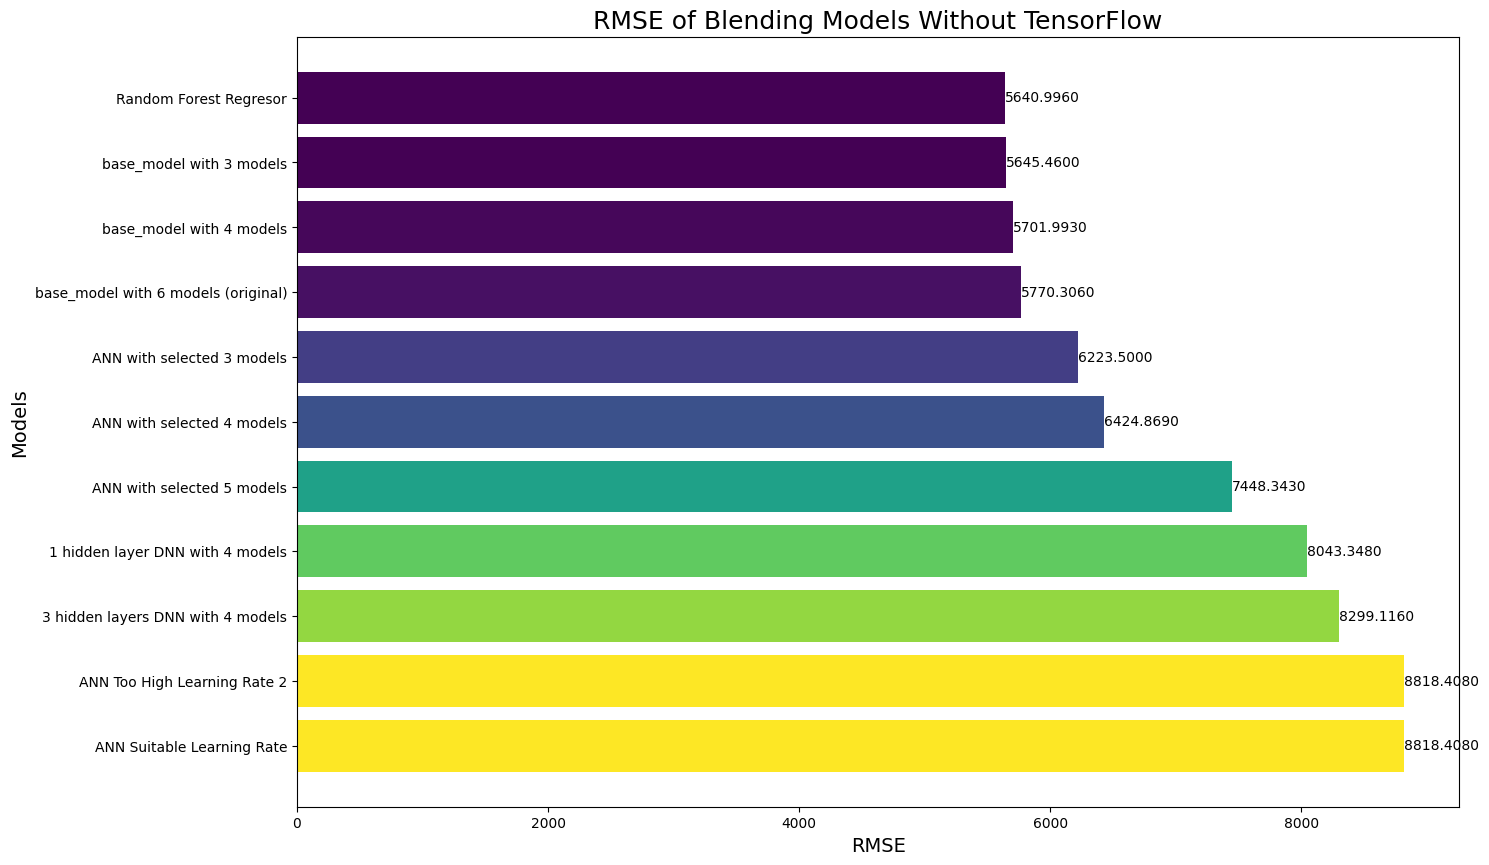

In [ ]:
# colors
class_rmse = list(results_no_tensorflow_df.values[:, 0])
denominator = max(class_rmse) - min(class_rmse)
scaled_data = [(datum-min(class_rmse))/denominator for datum in class_rmse]
colors = []
cmap = plt.colormaps['viridis']
for decimal in scaled_data:
  colors.append(cmap(decimal));

# plotting
fig = plt.subplots(figsize=(15, 10))
scores = plt.barh(results_no_tensorflow_df.index, results_no_tensorflow_df['RMSE'], color=colors)
plt.title('RMSE of Blending Models Without TensorFlow', fontsize=18)
plt.bar_label(scores, fmt='%.4f')
plt.gca().invert_yaxis()
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.savefig("/content/drive/MyDrive/ColabNotebooks/projects/AutoPartner/improved_blending_models_no_tf.png", bbox_inches='tight')
plt.show()

Wow I didn't do that well with my own implementation of blending algorithm neural network, but I really imrpoved the blending algorithm with 4 selected models

In [ ]:
tf_model_1_result = np.sqrt(mean_squared_error(y_test_formatted, tf_model_1.predict(meta_X_test_formatted_original)))
tf_model_2_result = np.sqrt(mean_squared_error(y_test_formatted, tf_model_2.predict(meta_X_test_formatted_original)))
tf_model_3_result = np.sqrt(mean_squared_error(y_test_formatted, tf_model_3.predict(meta_X_test_formatted_original)))
tf_model_4_result = np.sqrt(mean_squared_error(y_test_formatted, tf_model_4.predict(meta_X_test_formatted_original)))
tf_model_5_result = np.sqrt(mean_squared_error(y_test_formatted, tf_model_5.predict(meta_X_test_formatted_original)))
tf_model_6_result = np.sqrt(mean_squared_error(y_test_formatted, tf_model_6.predict(meta_X_test_formatted_selected_2)))

27/27 [==============================] - 0s 2ms/step


In [ ]:
results_tensorflow = {
    'Random Forest Regresor': rfr_result,
    'base_model with 6 models': bl_result,
    'base_model with 3 models (best RMSE)': bl_3_result,
    'ANN but with selected 3 models (Best NN model without Tensorflow)': model_6_result,
    '1 hidden layer Tensorflow model with SGD': tf_model_1_result,
    '1 hidden layer Tensorflow model with Adam': tf_model_2_result,
    '1 hidden layer Tensorflow model with Adam with linear activation': tf_model_3_result,
    '3 hidden layer Tensorflow model with Adam': tf_model_4_result,
    '3 hidden layer Tensorflow model with Adam with leaky relu': tf_model_5_result,
    '3 hidden layer Tensorflow model with Adam with leaky relu and 4 selected models': tf_model_6_result,
}

results_tensorflow_df = pd.DataFrame.from_dict(results_tensorflow, orient='index', columns=['RMSE']).round(3)
results_tensorflow_df.sort_values(by='RMSE', ascending=True, inplace=True)
results_tensorflow_df

,RMSE
3 hidden layer Tensorflow model with Adam with leaky relu and 4 selected models,5531.608
3 hidden layer Tensorflow model with Adam,5583.249
3 hidden layer Tensorflow model with Adam with leaky relu,5585.303
Random Forest Regresor,5640.996
base_model with 3 models (best RMSE),5645.460
base_model with 6 models,5770.306
ANN but with selected 3 models (Best NN model without Tensorflow),6223.500
1 hidden layer Tensorflow model with Adam,9146.138
1 hidden layer Tensorflow model with Adam with linear activation,9213.550
1 hidden layer Tensorflow model with SGD,10788.709


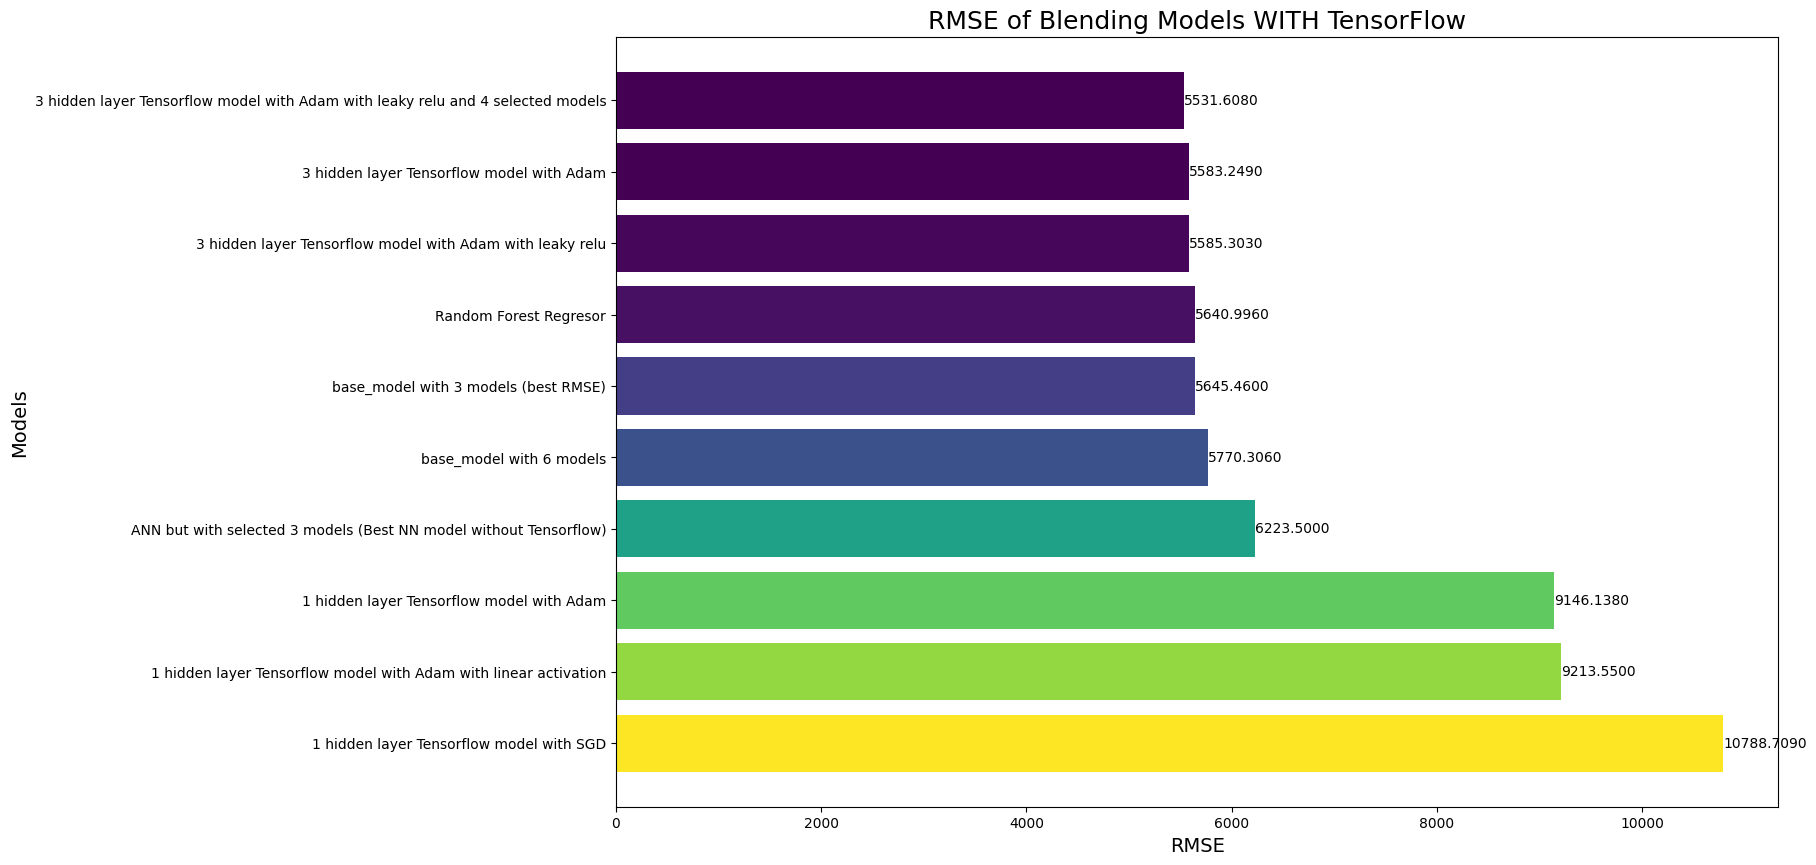

In [ ]:
# colors
class_tf_rmse = list(results_no_tensorflow_df.values[:, 0])
denominator = max(class_tf_rmse) - min(class_tf_rmse)
scaled_data = [(datum-min(class_tf_rmse))/denominator for datum in class_tf_rmse]
colors = []
cmap = plt.colormaps['viridis']
for decimal in scaled_data:
  colors.append(cmap(decimal));

# plotting
fig = plt.subplots(figsize=(15, 10))

scores = plt.barh(results_tensorflow_df.index, results_tensorflow_df['RMSE'], color=colors)
plt.title('RMSE of Blending Models WITH TensorFlow', fontsize=18)
plt.bar_label(scores, fmt='%.4f')
plt.gca().invert_yaxis()
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.savefig("/content/drive/MyDrive/ColabNotebooks/projects/AutoPartner/improved_blending_models_WITH_tf.png", bbox_inches='tight')
plt.show()

In [ ]:
y_pred = rfr.predict(X_test)
rfr_mape = mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

11.067134754232342

In [ ]:
y_pred = bl.predict(X_test)
bl_mape = mean_absolute_percentage_error(y_test, y_pred)

[[ 5901.33435822  7528.6        13389.4261153   8727.6
   7470.05419922 11715.6860177 ]
 [10866.39821329 10015.8        13396.62124929  6641.77
   6347.87255859 10628.02708124]
 [10897.83038462 16953.8        13669.86162458 26166.04333333
  20737.27148438 22066.28655545]
 ...
 [13807.77279959 15248.6        13639.9911484  18166.95
  17440.50585938 13287.70410367]
 [ 9369.94474428  1260.4        13464.89718239  2680.14
   7542.328125   14867.00841346]
 [-1049.20662526  5749.         13361.13968356  3644.26
   4275.36083984 11715.6860177 ]]


In [ ]:
y_pred = bl_2.predict(X_test)
bl_2_mape = mean_absolute_percentage_error(y_test, y_pred)

[[ 5032.88420017  7462.          8699.38        7525.36962891]
 [ 9827.49532321  9673.2         6768.82        7304.60888672]
 [11564.37370065 18710.         23598.35       22048.55664062]
 ...
 [13648.785401   14809.6        17559.99       17515.69335938]
 [ 9746.29877945  1649.2         2047.41        7012.87060547]
 [ -808.36141866  4902.2         3857.06        3278.0534668 ]]


In [ ]:
y_pred = net_8.predict(meta_X_test_formatted_selected_2)
best_nn_mape = mean_absolute_percentage_error(y_test_formatted, y_pred)

In [ ]:
y_pred = tf_model_6.predict(meta_X_test_formatted_selected_2)
best_tf_nn_mape = mean_absolute_percentage_error(y_test_formatted, y_pred)

27/27 [==============================] - 0s 2ms/step


In [ ]:
print(f'Random Forest Regressor:\n MAPE: {rfr_mape:.2f}% \n MRSE: {rfr_result:.2f}\n')
print(f'Improved blending algorithm:\n MAPE: {bl_2_mape:.2f}% \n MRSE: {bl_2_result:.2f}\n')
print(f'Original blending algorithm:\n MAPE: {bl_mape:.2f}% \n MRSE: {bl_result:.2f} \n')
print(f'Best NN Blending without tensorflow:\n MAPE: {best_nn_mape:.2f}% \n MRSE: {model_8_result:.2f} \n')
print(f'Best NN Blending WITH tensorflow:\n MAPE: {best_tf_nn_mape:.2f}% \n MRSE: {tf_model_6_result:.2f} \n')

Random Forest Regressor:
 MAPE: 11.07% 
 MRSE: 5641.00

Improved blending algorithm:
 MAPE: 11.24% 
 MRSE: 5701.99

Original blending algorithm:
 MAPE: 11.77% 
 MRSE: 5770.31 

Best NN Blending without tensorflow:
 MAPE: 7.67% 
 MRSE: 8299.12 

Best NN Blending WITH tensorflow:
 MAPE: 7.61% 
 MRSE: 5531.61 



In [ ]:
results_best_models = {
    'Improved blending algorithm': [bl_2_mape, bl_2_result],
    'Original blending algorithm': [bl_mape, bl_result],
    'Random Forest Regressor': [rfr_mape, rfr_result],
    'Best NN Blending without tensorflow': [best_nn_mape, model_8_result],
    'Best NN Blending WITH tensorflow': [best_tf_nn_mape, tf_model_4_result],
}

results_best_models_df = pd.DataFrame.from_dict(results_best_models, orient='index', columns=['MAPE(%)', 'RMSE']).round(3)
results_best_models_df.sort_values(by='RMSE', ascending=True, inplace=True)
results_best_models_df

,MAPE(%),RMSE
Best NN Blending WITH tensorflow,7.608,5583.249
Random Forest Regressor,11.067,5640.996
Improved blending algorithm,11.239,5701.993
Original blending algorithm,11.769,5770.306
Best NN Blending without tensorflow,7.669,8299.116


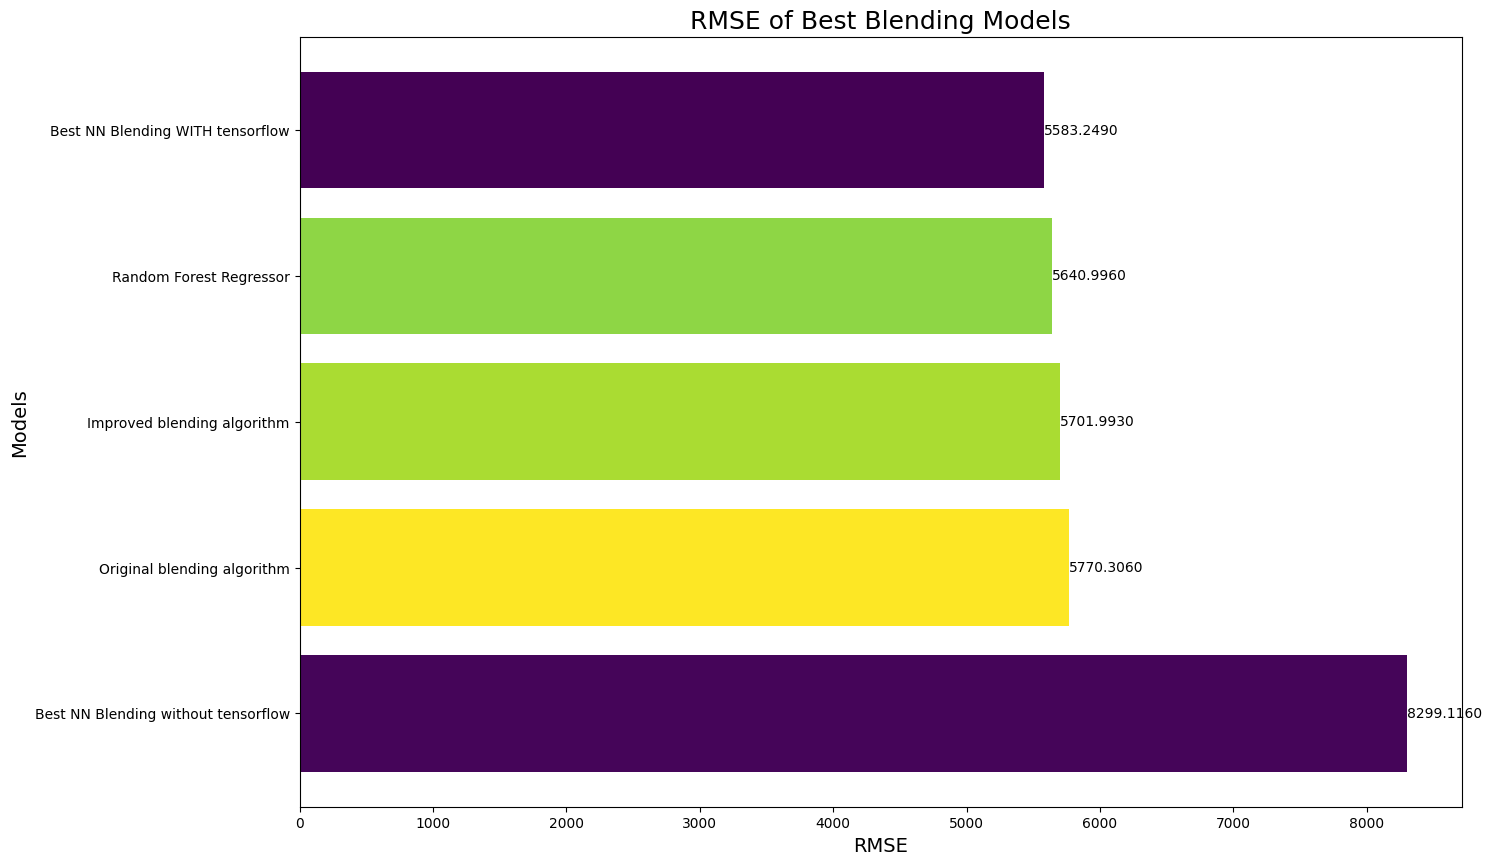

In [ ]:
# colors
best_models_scores = list(results_best_models_df.values[:, 0])
denominator = max(best_models_scores) - min(best_models_scores)
scaled_data = [(datum-min(best_models_scores))/denominator for datum in best_models_scores]
colors = []
cmap = plt.colormaps['viridis']
for decimal in scaled_data:
  colors.append(cmap(decimal));

# plotting
fig = plt.subplots(figsize=(15, 10))

scores = plt.barh(results_best_models_df.index, results_best_models_df['RMSE'], color=colors)
plt.title('RMSE of Best Blending Models', fontsize=18)
plt.bar_label(scores, fmt='%.4f')
plt.gca().invert_yaxis()
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.savefig("/content/drive/MyDrive/ColabNotebooks/projects/AutoPartner/best_models_rmse.png", bbox_inches='tight')
plt.show()

In [ ]:
results_best_models_df.sort_values(by='MAPE(%)', ascending=True, inplace=True)

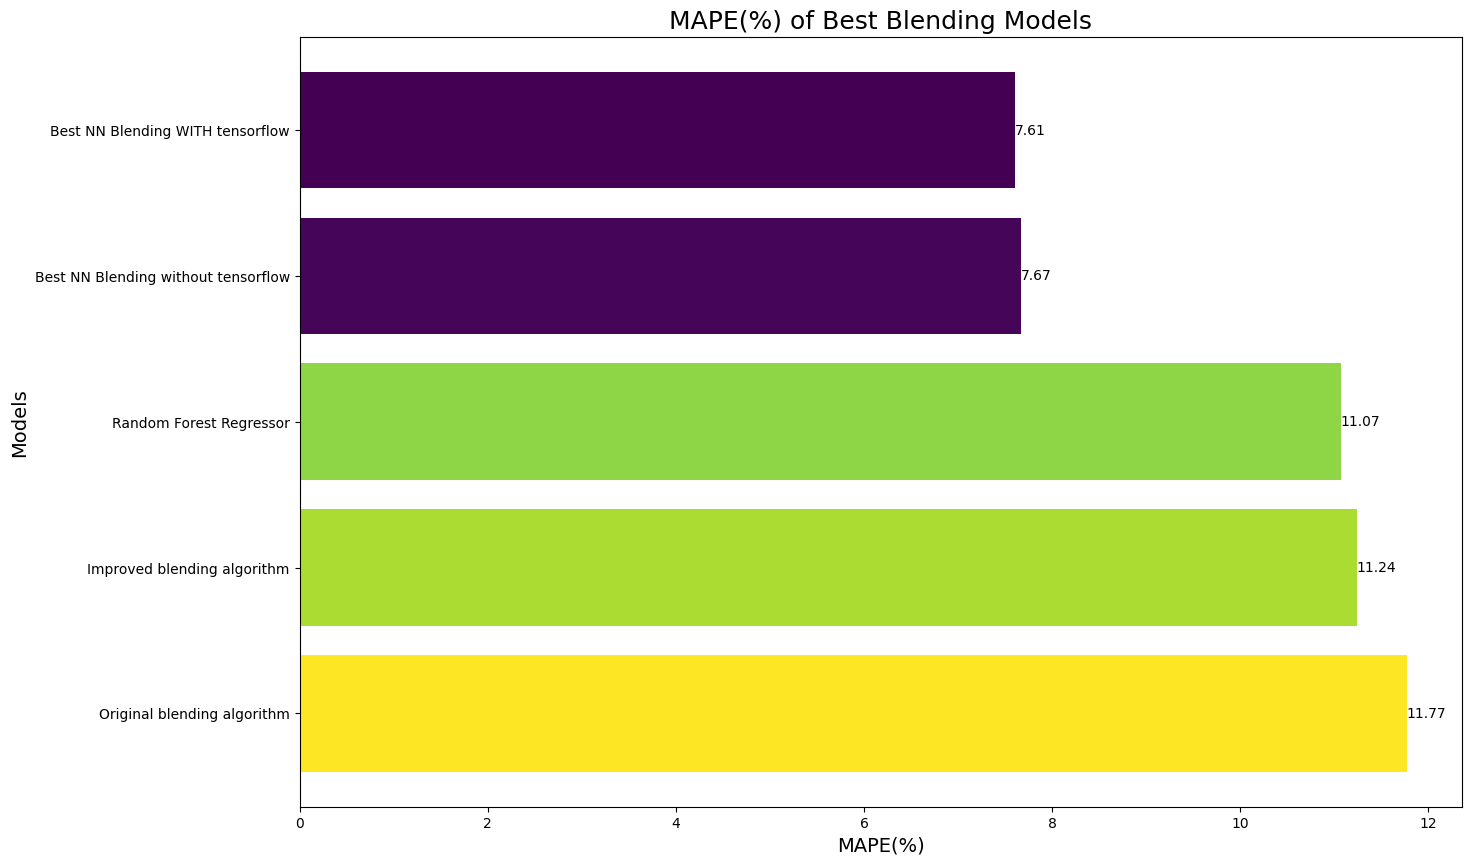

In [ ]:
# colors
best_models_scores = list(results_best_models_df.values[:, 0])
denominator = max(best_models_scores) - min(best_models_scores)
scaled_data = [(datum-min(best_models_scores))/denominator for datum in best_models_scores]
colors = []
cmap = plt.colormaps['viridis']
for decimal in scaled_data:
  colors.append(cmap(decimal));

# plotting
fig = plt.subplots(figsize=(15, 10))

scores = plt.barh(results_best_models_df.index, results_best_models_df['MAPE(%)'], color=colors)
plt.title('MAPE(%) of Best Blending Models', fontsize=18)
plt.bar_label(scores, fmt='%.2f')
plt.gca().invert_yaxis()
plt.xlabel('MAPE(%)', fontsize=14)
plt.ylabel('Models', fontsize=14)

plt.savefig("/content/drive/MyDrive/ColabNotebooks/projects/AutoPartner/best_models_mape.png", bbox_inches='tight')
plt.show()

## Conclusion

The best RMSE with my own implementation is 8229.1160, which is worse than the original blending algorithm (5770.360) and previous best model (5169.220). However, it has lower MAPE with only 7.67%, better than the original blending algorithm (11.77%) and previous best model (13.77%).

However, I've succeeded in improving the MLP blending algorithm with only 3 models, it has an RMSE score of 5701.9930 and MAPE of 11.24%, which is better than the original blending score.

The best model is the blending algorithm neural networks with TensorFlow with RMSE of 5583.2490 and MAPE of 7.61%


Below is the past model's performance I've created:

![image](https://drive.google.com/uc?export=view&id=1g8ppaUiQHGHlS2-bHo6CvWxdtsk8TiGJ)